# Protein Folding with QAOA: A Comprehensive Study

This notebook demonstrates the application of the Quantum Approximate Optimization Algorithm (QAOA) to the protein folding problem using the HP (Hydrophobic-Polar) lattice model.

## Table of Contents

1. [**Setup and Imports**](#setup-and-imports) - Import required libraries and configure environment
2. [**Problem Definition**](#2-problem-definition-hp-lattice-model) - HP lattice model and protein sequence setup
3. [**Hamiltonian Construction**](#3-hamiltonian-construction) - Building the cost and mixer Hamiltonians
4. [**QAOA Implementation**](#4-qaoa-implementation) - Quantum circuit and probability calculations
5. [**Optimization Methods**](#5-optimization-methods) - Various parameter optimization approaches:
   - [Gradient Descent](#method-1-gradient-descent-optimization)
   - [Grid Search (p=1)](#method-2-grid-search-p1)
   - [Grid Search with JAX (p=2)](#method-3-grid-search-with-jax-p2)
   - [Quantum Annealing Initialization](#method-4-quantum-annealing-initialization)
   - [Parameter Interpolation](#method-5-parameter-interpolation)
6. [**Results and Analysis**](#6-results-and-analysis) - Comparison of methods and final results



## Problem Overview

The HP lattice model represents proteins as chains of amino acids on a 2D lattice, where each amino acid is classified as either:
- **H (Hydrophobic)**: Tends to cluster together
- **P (Polar)**: Prefers to be on the surface

The goal is to find the configuration that minimizes the energy by maximizing H-H contacts while avoiding overlaps.

**Reference**: Based on Irbäck et al. 2022: [Phys. Rev. Research 4, 043013](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.4.043013)

In [1]:
# =============================================================================
# SETUP AND IMPORTS
# =============================================================================

# Core libraries
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from typing import List, Union

# Quantum computing
import pennylane as qml
from pennylane import numpy as pnp
from pennylane import qaoa

# Optimization libraries
try:
    import jax
    import jax.numpy as jnp
    from jax import jit, value_and_grad
    
    # Configure JAX for better compatibility (newer API)
    try:
        # Try the older API first
        jax.config.update("jax_enable_x64", True)
        jax.config.update("jax_platform_name", "cpu")  # Force CPU to avoid CUDA issues
    except AttributeError:
        # Use newer API for JAX configuration
        import os
        os.environ['JAX_ENABLE_X64'] = 'True'
        os.environ['JAX_PLATFORM_NAME'] = 'cpu'
        print("Using JAX environment variables for configuration")
    
    JAX_AVAILABLE = True
    print("JAX is available for accelerated computations (CPU mode)")
except (ImportError, AttributeError) as e:
    print(f"JAX not available or configuration failed: {e}")
    print("Some optimizations will be skipped.")
    JAX_AVAILABLE = False


JAX is available for accelerated computations (CPU mode)


In [2]:

# =============================================================================
# CONFIGURATION
# =============================================================================

# Problem configuration
SEQUENCE = [1, 0, 0, 1]  # HPPH sequence
LATTICE_SIZE = (3, 2)    # 3x2 lattice
LAMBDA_VECTOR = (2.1, 2.4, 3.0)  # Penalty coefficients
MAX_STEPS = 50           # Maximum optimization steps
GRID_POINTS = 20         # Grid points for parameter search
p = 1                    # QAOA depth (number of layers)

# Display configuration
print(f"Protein sequence: {SEQUENCE} (HPPH)")
print(f"Lattice size: {LATTICE_SIZE}")
print(f"Lambda vector: {LAMBDA_VECTOR}")
print(f"Max optimization steps: {MAX_STEPS}")
print(f"Grid search points: {GRID_POINTS}")
print(f"QAOA depth: {p}")

Protein sequence: [1, 0, 0, 1] (HPPH)
Lattice size: (3, 2)
Lambda vector: (2.1, 2.4, 3.0)
Max optimization steps: 50
Grid search points: 20
QAOA depth: 1


# 2. Problem Definition: HP Lattice Model

The HP lattice model is a simplified representation of protein folding where:
- Amino acids are placed on a 2D lattice
- Each amino acid is either Hydrophobic (H=1) or Polar (P=0)
- The energy function favors H-H contacts while penalizing overlaps

Below we implement the `CoordinateBased_HPLattice` class that handles the lattice representation and energy calculations.

## Protein model

The HP-lattice model in two dimensions has two types of beads: H for hydrophobic and P for polar. We can make an instance of the model by defining the sequence with 1 for H and 0 for P and a lattice grid size.

The model is described in detail in Sec II. "Methods" part B "Binary quadratic model for HP lattice proteins – QUBO encoding" in Irbäck et al. 2022.
https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.4.043013

The energy function can be defined as:
\begin{equation}
    E = E_{HP} + \sum_{i=1}^3 \lambda_i E_i,
\end{equation}
where $E_{HP}$ is the energy term for the HP model and the terms $E_1$, $E_2$ and $E_3$ are constraint energies with the penalty vector $\lambda_i,\ i=1,2,3$ controlling the strength of the constraints.

\begin{equation}
    E_{HP} = - \sum_{|f-f'|>1}C(h_f, h_f') \sum_{(s,s')}\sigma_s^f\sigma_{s'}^{f'}
\end{equation}

\begin{equation}
    C(h_f,h_{f'}) =     \begin{cases}
      1, & \text{if } h_f = h_{f'} = \text{H}, \\
      0, & \text{otherwise}.
    \end{cases} 
\end{equation}

\begin{equation}
    E_1 = \sum_f \left(\sum_s\sigma_s^f-1\right)^2 + \left\{ \text{same for odd parity} \right\}
\end{equation}

\begin{equation}
    E_2 = \frac{1}{2} \sum_{f_1 \not = f_2} \sum_s \sigma_s^f\sum_{||s'-s||>1} \sigma_{s'}^{f+1} + \left\{ \text{same for odd parity} \right\}
\end{equation}

\begin{equation}
\begin{split}
    E_3 =& \sum_{1 \leq f<N} \sum_s \sigma_s^f \sum_{||s'-s||>1} \sigma_{s'}^{f+1} \\
    & + \left\{ \text{same with odd/even parity interchanged} \right\},
\end{split}
\end{equation}
where $\sigma_s^f$ to describe the location of the even beads. The index $f$ is the beads and $s$ is the sites (' are the odd beads and sites). The $\sigma_s^f=1$ if bead $f$ is located on site $s$, and $\sigma_s^f=0$ otherwise, same for odds. The sites and beads are divided into odds and even to reduce the number of bits required from the number of amino acids times the area of the grid to half.

The terms in the energy function can be clumped together to one-body energy $O_i$, and two-body interaction $T_{ij}$, the pairwise interaction potentials.
The energy function to optimize can be written as
\begin{equation}
    E(x) = \underbrace{\sum^N_{i=1} O_i x_i}_\text{one-body} + \underbrace{\sum^{N-1}_{i=1}\sum^N_{j=i+1} T_{ij}x_ix_j}_\text{two-body},
\end{equation}
where $x_i$ is a bitstring representing the folding on the lattice. $x_1$ is the choise, 1 for yes and 0 for no, of putting the first amino acid on position (0,0) on the grid.

In [3]:
# =============================================================================
# PROTEIN FOLDING UTILITIES IMPORT AND SETUP
# =============================================================================

# Import the HP lattice model class and utility functions
try:
    from protein_folding_utils import (
        CoordinateBased_HPLattice, 
        get_ground_states_i,
        get_ground_states_energy_and_indices,
        plot_probs_with_energy,
        grid_search,
        vec_grid_search_p2,
        get_annealing_params,
        interpolate_params,
        energies_of_set,
        energy_of_index,
        get_energies_index_states,
        index_set2bit_string,
        get_batch_array,
        plot_grid_search
    )
    print("✓ Successfully imported protein folding utilities")
except ImportError as e:
    print(f"Warning: Could not import utilities from separate file: {e}")
    print("Loading utilities inline instead...")
    
    # If the separate file is not available, we could load the utilities inline
    # For now, we'll assume the file is available
    


✓ Successfully imported protein folding utilities


In [4]:
# =============================================================================
# PROBLEM SETUP
# =============================================================================

# Create protein instance
protein = CoordinateBased_HPLattice(
    sequence=SEQUENCE,
    dim_lattice=LATTICE_SIZE, 
    lambda_vector=LAMBDA_VECTOR,
    verbose=True
)

print(protein)

# Calculate solution sets
print(f"\nProblem Statistics:")
print(f"Total possible solutions: {len(protein.solution_set):,}")
print(f"Feasible solutions: {len(protein.feasible_set):,}")
print(f"Feasible percentage: {protein.get_feasible_percentage():.2f}%")



QUBO matrix construction counts:
HP interactions: 56
One-per constraints (lambda 1): 36
Self-avoidance (lambda 2): 6
Connectivity (lambda 3): 6
Protein sequence: [1, 0, 0, 1]
Lattice dimensions: (3, 2)
Number of qubits: 12
Total solutions: 4096
Feasible solutions: 14
Feasible percentage: 0.34%

O:
[-2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1]
T:
[[ 0.   4.2  4.2  0.   0.   3.   2.4  0.   0.  -1.  -1.   0. ]
 [ 4.2  0.   4.2  0.   0.   0.   0.   2.4  0.  -1.  -1.  -1. ]
 [ 4.2  4.2  0.   3.   0.   0.   0.   0.   2.4  0.  -1.  -1. ]
 [ 0.   0.   3.   0.   4.2  4.2  0.   0.   0.   2.4  0.   0. ]
 [ 0.   0.   0.   4.2  0.   4.2  0.   0.   0.   0.   2.4  0. ]
 [ 3.   0.   0.   4.2  4.2  0.   0.   0.   0.   0.   0.   2.4]
 [ 2.4  0.   0.   0.   0.   0.   0.   4.2  4.2  0.   0.   3. ]
 [ 0.   2.4  0.   0.   0.   0.   4.2  0.   4.2  0.   0.   0. ]
 [ 0.   0.   2.4  0.   0.   0.   4.2  4.2  0.   3.   0.   0. ]
 [-1.  -1.   0.   2.4  0.   0.   0.   0.   3.   0.   4.2  

In [5]:
# =============================================================================
# PROBLEM VERIFICATION
# =============================================================================

# Verify the protein setup and display bit information
print('Bit names (format: ((x,y)-coordinate, sequence_index)):')
bit_names = protein.get_bit_names()
print(bit_names)

print(f'\nNumber of bits needed to encode one folding: {protein.num_bits}')
print(f'Feasible solutions as percentage of total: {protein.get_feasible_percentage():.2f}%')

# Get feasible set for further analysis
feasible_set = np.array(protein.feasible_set)
print(f'Feasible set shape: {feasible_set.shape}')

# Display some key problem statistics
print(f'\nProblem Statistics:')
print(f'  Sequence: {protein.sequence} (HPPH)')
print(f'  Lattice dimensions: {protein.dim_lattice}')
print(f'  Lambda vector: {protein.lambda_vector}')
print(f'  Total solution space: {len(protein.solution_set):,}')
print(f'  Feasible solutions: {len(protein.feasible_set):,}')

Bit names (format: ((x,y)-coordinate, sequence_index)):
[((0, 0), 0), ((1, 1), 0), ((2, 0), 0), ((0, 1), 1), ((1, 0), 1), ((2, 1), 1), ((0, 0), 2), ((1, 1), 2), ((2, 0), 2), ((0, 1), 3), ((1, 0), 3), ((2, 1), 3)]

Number of bits needed to encode one folding: 12
Feasible solutions as percentage of total: 0.34%
Feasible set shape: (14, 12)

Problem Statistics:
  Sequence: [1, 0, 0, 1] (HPPH)
  Lattice dimensions: (3, 2)
  Lambda vector: (2.1, 2.4, 3.0)
  Total solution space: 4,096
  Feasible solutions: 14


First solution in the feasible solution set: 
[((0, 0), 0), ((0, 1), 1), ((1, 1), 2), ((1, 0), 3)]


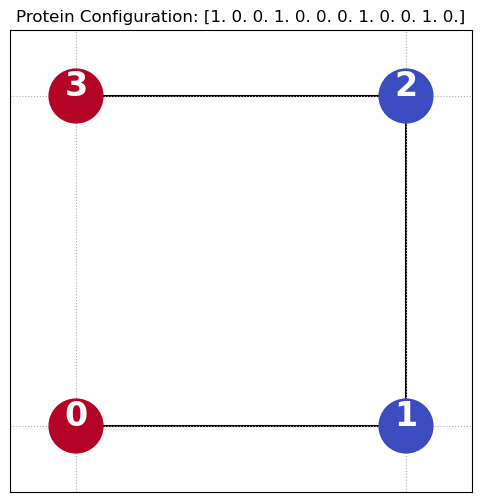

In [6]:
# Draw the protein
print('First solution in the feasible solution set: ')
x = [True if x > 0 else False for x in feasible_set[0]]
y = protein.get_bit_names()
print([b for a, b in zip(x, y) if a])

protein.viz_lattice(feasible_set[0])

<Figure size 640x480 with 0 Axes>

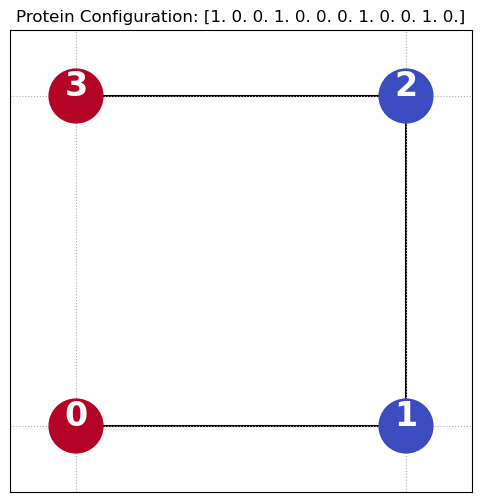

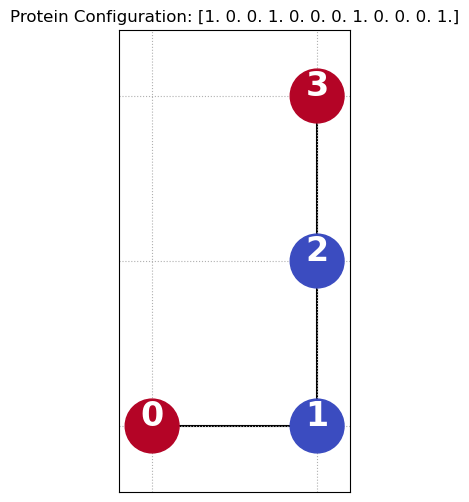

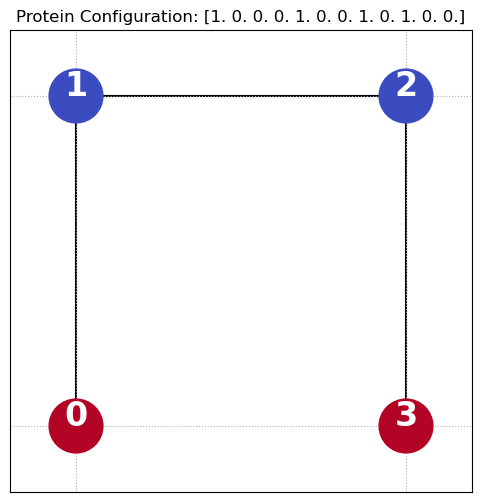

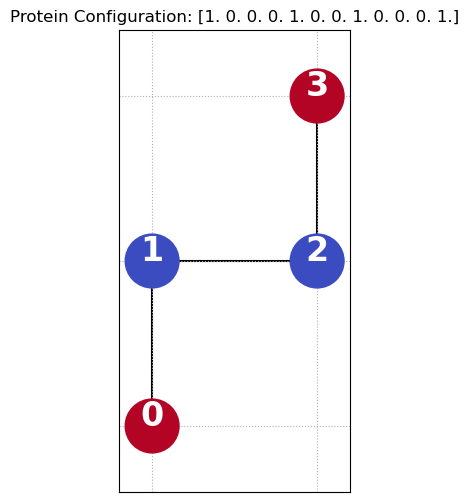

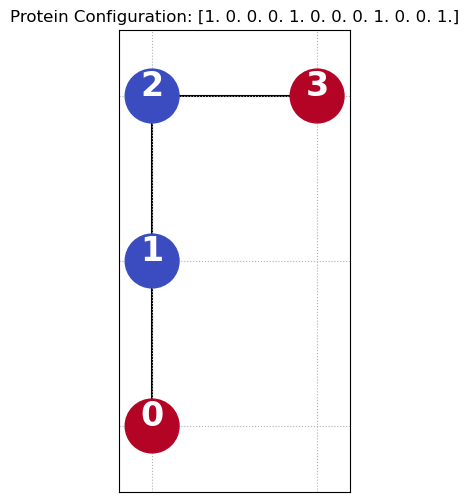

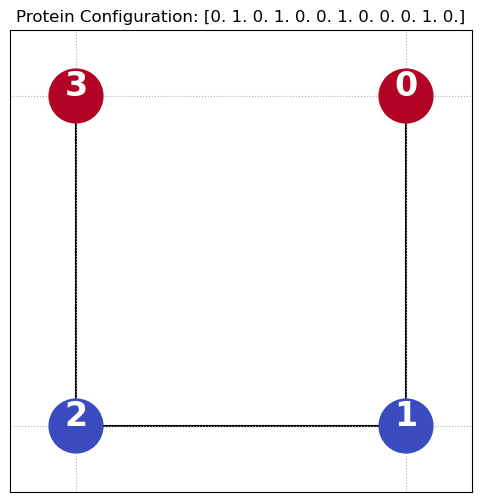

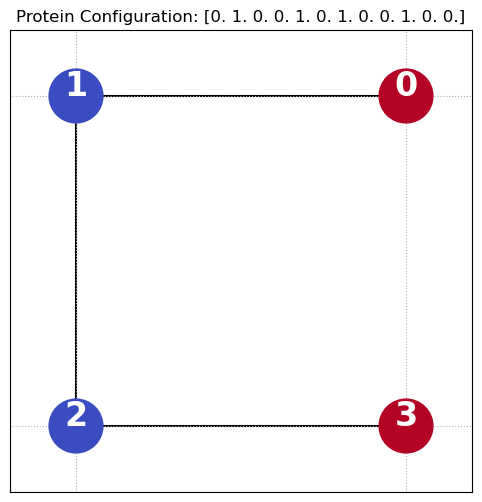

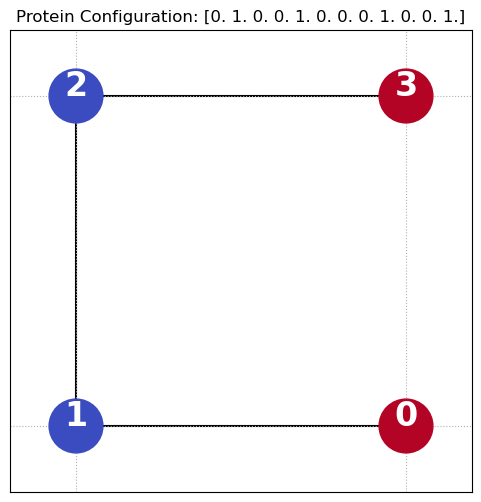

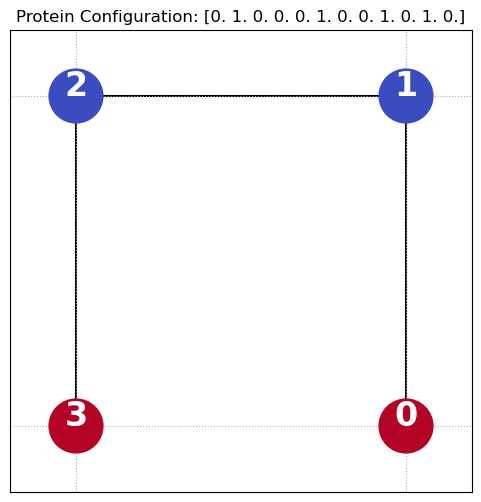

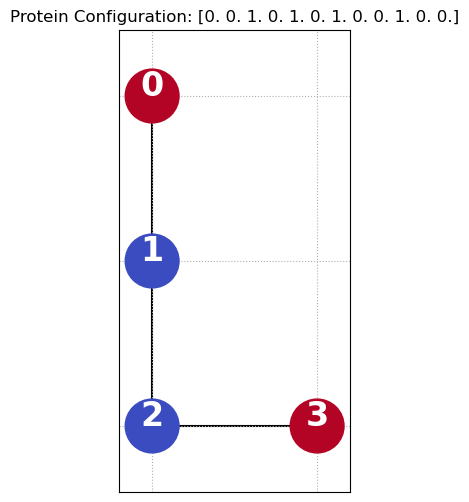

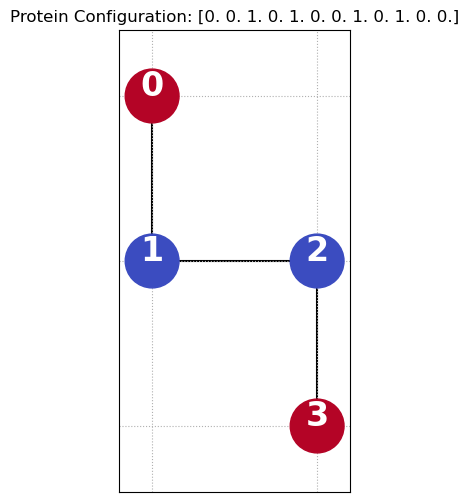

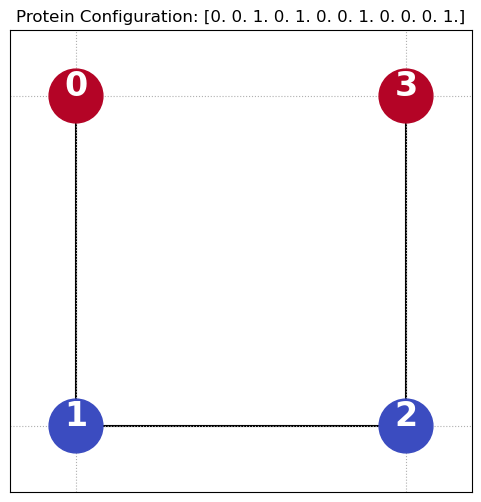

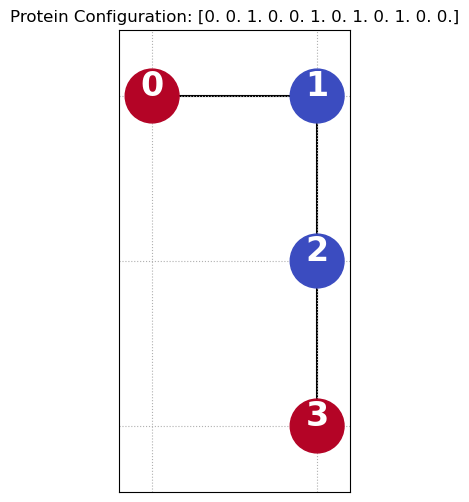

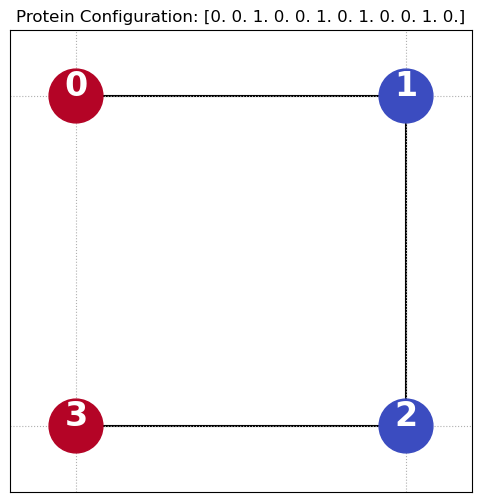

In [7]:
# Draw all proteins in feasible solution set
for j,i in enumerate(feasible_set):
    plt.figure(j)
    protein.viz_lattice(i)

# 3. Hamiltonian Construction

## Quantum Approximate Optimization Algorithm (QAOA)
In QAOA, the circuit is done in a sequence of depth $p$:
\begin{equation}
    \begin{split}
        |\psi_p(\gamma, \beta) \rangle = & e^{-i\beta_p H_{mixer}} e^{-i\gamma_p H_{\text{cost}}}\\
        &... e^{-i\beta_1 H_{mixer}} e^{-i\gamma_1 H_{\text{cost}}} | \psi_{\text{init.}} \rangle,
    \end{split}
\end{equation}
where $\gamma$ and $\beta$ are vectors of parameters to optimize by a classical computer so that the probability of measuring the optimal state is high.

The function to optimize is often the expectation value
\begin{equation}
    C_{\text{obj.}} = \langle \psi_p(\gamma, \beta) | H_{cost} | \psi_p(\gamma, \beta) \rangle,
\end{equation}
where $C_{\text{obj.}}$ is the energy function in our case.
If we get the lowest expectation value, we should get the answer with the lowest energy.

For details on how to run QAOA in Pennylane: https://pennylane.ai/qml/demos/tutorial_qaoa_intro

## Protein Instance to Cost Hamiltonian

Here, we create a cost Hamiltonian from the protein by translating the binary variables $x_i=\{0,1\}$ to spin $q_i=\{1,-1\}$ for the qubits. We end up with a problem on the form of an Ising Hamiltonian:

\begin{equation}
    H_{\text{cost}} = \sum_i h_i \sigma_i^z + \sum_{ij} J_{ij} \sigma_i^z \sigma_j^z,
\end{equation}
where $h_i$ are the field constants applied to qubit $i$ translated from the one-body energies, $J_{ij}$ are the two-body interaction constants between qubit $i$ and $j$ translated from the two-body energies and $\sigma^z$ is the Pauli operator in the $z$-direction.

In [8]:
def protein_folding_hamiltonian(ProteinInstance) -> 'qml.Hamiltonian':
	"""
	Construct the complete cost Hamiltonian for protein folding optimization.
	
	This function converts the classical HP lattice protein folding problem into 
	a quantum Hamiltonian suitable for QAOA optimization. It transforms the binary 
	variables x_i ∈ {0,1} to spin variables q_i ∈ {-1,1} for qubits.
	
	Args:
		ProteinInstance (CoordinateBased_HPLattice): HP lattice instance containing O_energies 
						(one-body terms) and T_energies (two-body interaction terms)
	
	Returns:
		qml.Hamiltonian: Complete cost Hamiltonian H_cost = H_O + H_T in Ising form
		
	Note:
		QUBO to Ising conversion uses scaling factors: hᵢ = -O_energies[i]/2, Jᵢⱼ = T_energies[i,j]/4
	"""
	num_qubits = len(ProteinInstance.O_energies)
	wires = range(ProteinInstance.num_bits)

	# Convert one-body QUBO coefficients to Ising field terms
	O_coeffs = [-x/2 for x in ProteinInstance.O_energies] 

	# Convert two-body QUBO coefficients to Ising interaction terms
	T_coeffs = np.copy(ProteinInstance.T_energies)
	for j in range(num_qubits):                         
		for k in range(num_qubits):
			T_coeffs[j,k] = T_coeffs[j,k]/4

	H_cost = get_cost_hamiltonian(O_coeffs, T_coeffs, wires)
	return H_cost

def get_cost_hamiltonian(O_coeffs: List[float], T_coeffs: np.ndarray, wires: range) -> 'qml.Hamiltonian':
	"""
	Combine one-body and two-body terms into the complete cost Hamiltonian.
	
	Args:
		O_coeffs (List[float]): List of coefficients for one-body Pauli-Z terms (field terms)
		T_coeffs (np.ndarray): Matrix of coefficients for two-body Pauli-Z interactions  
		wires (range): Range of qubit indices for the Hamiltonian
		
	Returns:
		qml.Hamiltonian: Combined Hamiltonian H_cost = H_O + H_T
	"""
	H_cost_O = get_O_hamiltonian(O_coeffs, wires)
	H_cost_T = get_T_hamiltonian(T_coeffs, wires)
	return H_cost_O + H_cost_T

def get_O_hamiltonian(O_coeffs: List[float], wires: range) -> 'qml.Hamiltonian':
	"""
	Construct the one-body (field) part of the Hamiltonian.
	
	Creates H_O = Σᵢ hᵢ σᵢᶻ where hᵢ are the field coefficients.
	
	Args:
		O_coeffs (List[float]): List of field coefficients for each qubit
		wires (range): Range of qubit indices
		
	Returns:
		qml.Hamiltonian: One-body Hamiltonian with Pauli-Z terms
	"""
	return qml.Hamiltonian(O_coeffs, [qml.PauliZ(i) for i in wires])

def get_T_hamiltonian(T_coeffs: np.ndarray, wires: range) -> 'qml.Hamiltonian':
	"""
	Construct the two-body (interaction) part of the Hamiltonian.
	
	Creates H_T = Σᵢⱼ Jᵢⱼ σᵢᶻ σⱼᶻ from the QUBO two-body terms.
	The QUBO term T_ij * x_i * x_j is converted to Ising form by expanding:
	x_i * x_j = (1 + σᵢᶻ)(1 + σⱼᶻ)/4 = 1/4 + σᵢᶻ/4 + σⱼᶻ/4 + σᵢᶻσⱼᶻ/4
	
	Args:
		T_coeffs (np.ndarray): Matrix of two-body interaction coefficients
		wires (range): Range of qubit indices
		
	Returns:
		qml.Hamiltonian: Two-body interaction Hamiltonian with Pauli-Z terms
		
	Note:
		Each QUBO term T_ij * x_i * x_j contributes: T_coeffs[j,k] * σⱼᶻ σₖᶻ, 
		-T_coeffs[j,k] * σⱼᶻ, and -T_coeffs[j,k] * σₖᶻ to the Ising Hamiltonian.
	"""
	obs = []
	coeffs = []
	for j in wires:
		for k in range(j+1, len(wires)):
			# Two-body interaction term: T_coeffs[j,k] * σⱼᶻ σₖᶻ
			coeffs.append(T_coeffs[j,k]) 
			
			# Field correction terms from QUBO-to-Ising conversion
			coeffs.append(-T_coeffs[j,k])  # -T_coeffs[j,k] * σⱼᶻ
			
			coeffs.append(-T_coeffs[j,k])

			obs.append(qml.PauliZ(j) @ qml.PauliZ(k))
			obs.append(qml.PauliZ(j))			
			obs.append(qml.PauliZ(k))
			
	return qml.Hamiltonian(coeffs, obs)

In [9]:
# Make into Hamiltonian
H_cost = protein_folding_hamiltonian(protein)
num_qubits = protein.num_bits
qubits = range(protein.num_bits) # naming the qubits
print('H_cost:\n' + str(H_cost))

H_cost:
1.05 * Z(0) + 1.05 * Z(1) + 1.05 * Z(2) + 1.05 * Z(3) + 1.05 * Z(4) + 1.05 * Z(5) + 1.05 * Z(6) + 1.05 * Z(7) + 1.05 * Z(8) + 1.05 * Z(9) + 1.05 * Z(10) + 1.05 * Z(11) + 1.05 * (Z(0) @ Z(1)) + -1.05 * Z(0) + -1.05 * Z(1) + 1.05 * (Z(0) @ Z(2)) + -1.05 * Z(0) + -1.05 * Z(2) + 0.0 * (Z(0) @ Z(3)) + -0.0 * Z(0) + -0.0 * Z(3) + 0.0 * (Z(0) @ Z(4)) + -0.0 * Z(0) + -0.0 * Z(4) + 0.75 * (Z(0) @ Z(5)) + -0.75 * Z(0) + -0.75 * Z(5) + 0.6 * (Z(0) @ Z(6)) + -0.6 * Z(0) + -0.6 * Z(6) + 0.0 * (Z(0) @ Z(7)) + -0.0 * Z(0) + -0.0 * Z(7) + 0.0 * (Z(0) @ Z(8)) + -0.0 * Z(0) + -0.0 * Z(8) + -0.25 * (Z(0) @ Z(9)) + 0.25 * Z(0) + 0.25 * Z(9) + -0.25 * (Z(0) @ Z(10)) + 0.25 * Z(0) + 0.25 * Z(10) + 0.0 * (Z(0) @ Z(11)) + -0.0 * Z(0) + -0.0 * Z(11) + 1.05 * (Z(1) @ Z(2)) + -1.05 * Z(1) + -1.05 * Z(2) + 0.0 * (Z(1) @ Z(3)) + -0.0 * Z(1) + -0.0 * Z(3) + 0.0 * (Z(1) @ Z(4)) + -0.0 * Z(1) + -0.0 * Z(4) + 0.0 * (Z(1) @ Z(5)) + -0.0 * Z(1) + -0.0 * Z(5) + 0.0 * (Z(1) @ Z(6)) + -0.0 * Z(1) + -0.0 * Z(6) + 0.

### Ground state of the cost Hamiltonian
The native states of the protein are the ground states of the cost Hamiltonian. We need it to benchmark our algorithm's performance.

# 4. QAOA Implementation

Now we implement the QAOA circuit and create the quantum device for simulation. We'll set up the cost and mixer Hamiltonians, then create the quantum circuits for parameter optimization.

In [10]:
ground_energy, ground_states_index = get_ground_states_energy_and_indices(feasible_set, H_cost) # get the ground states

# This function is cheating! It is an extensive search through all solutions to find the one with the lowest energy.
# But we use it for benchmarking our algorithm on small problem instances.
print('Ground energy: ', ground_energy)

Ground energy:  -14.25


### We also need a mixer Hamiltonian for our QAOA

Pennylane has a command to get a simple X-mixer:
\begin{equation}
    H_{\text{mixer}} = \sum_i \sigma_i^x.
\end{equation}
where $\sigma^x$ is the Pauli operator in the $x$-direction.

# 5. Optimization Methods

We will explore several different approaches to optimize the QAOA parameters:

1. **Gradient Descent** - Classical gradient-based optimization
2. **Grid Search (p=1)** - Exhaustive search over parameter space for depth 1
3. **Grid Search with JAX (p=2)** - Accelerated grid search for depth 2
4. **Quantum Annealing Initialization** - Physics-inspired parameter initialization
5. **Parameter Interpolation** - Systematic parameter scaling

Let's start with gradient descent optimization.

In [11]:
# Set up the mixer Hamiltonian for QAOA
H_mixer = qaoa.x_mixer(qubits)
print('H_mixer:\n' + str(H_mixer))

# Set up the quantum device
dev = qml.device('default.qubit', wires=qubits)

# Define the QAOA layer
def qaoa_layer(gamma: float, beta: float) -> None:
    """
    Apply a single layer of the QAOA algorithm.
    
    This function implements one QAOA layer consisting of:
    1. Cost layer: applies e^(-iγH_cost) evolution
    2. Mixer layer: applies e^(-iβH_mixer) evolution
    
    Args:
        gamma (float): Cost parameter controlling the strength of cost Hamiltonian evolution (range: [0, π])
        beta (float): Mixer parameter controlling the strength of mixer Hamiltonian evolution (range: [0, π/2])
        
    Returns:
        None: Function applies quantum operations in-place
        
    Note:
        Uses PennyLane's built-in qaoa.cost_layer and qaoa.mixer_layer functions.
        Cost layer encodes problem structure, mixer layer enables solution space exploration.
    """
    qaoa.cost_layer(gamma, H_cost)
    qaoa.mixer_layer(beta, H_mixer)
    
# Define the QAOA circuit
def circuit(params: np.ndarray) -> None:     
    """
    Construct the complete QAOA circuit for QUBO optimization.
    
    This function creates a parameterized quantum circuit that:
    1. Initializes all qubits in superposition (|+⟩ state)
    2. Applies p layers of QAOA evolution alternating between cost and mixer Hamiltonians
    
    The circuit implements the QAOA ansatz:
    |ψ(γ,β)⟩ = ∏_{j=1}^p e^(-iβ_j H_mixer) e^(-iγ_j H_cost) |+⟩^⊗n
    
    Args:
        params (np.ndarray): Array of shape (2, p) where params[0] contains p gamma (cost) parameters
                            and params[1] contains p beta (mixer) parameters
        
    Returns:
        None: Function constructs quantum circuit in-place
        
    Note:
        Uses qml.layer to systematically apply multiple QAOA layers. The number of layers p 
        is inferred from len(params[0]). Initial state |+⟩^⊗n created by Hadamard gates.
    """
    # Start in superposition (Hadamard on all qubits)
    for q in qubits:     
        qml.Hadamard(wires=q)
    # Apply QAOA layers
    qml.layer(qaoa_layer, len(params[0]), params[0], params[1]) 

# Define the cost function (expectation value of H_cost)
@qml.qnode(dev)
def average_cost(params: np.ndarray) -> float:
    """
    Compute the expectation value of the cost Hamiltonian for given QAOA parameters.
    
    This function evaluates the objective function for QAOA optimization:
    ⟨ψ(γ,β)|H_cost|ψ(γ,β)⟩ where |ψ(γ,β)⟩ is the QAOA state prepared by the circuit function.
    Lower values indicate better solutions (lower energy protein conformations).
    
    Args:
        params (np.ndarray): QAOA parameters of shape (2, p) where params[0] contains gamma parameters
                            (cost evolution angles) and params[1] contains beta parameters (mixer evolution angles)
        
    Returns:
        float: Expectation value of the cost Hamiltonian
        
    Note:
        This function is decorated with @qml.qnode for quantum computation and is used as 
        the objective function in optimization algorithms. Ground state energy corresponds 
        to the optimal protein folding.
    """
    circuit(params)
    return qml.expval(H_cost)

# Define the probability measurement circuit
@qml.qnode(dev)
def probability_circuit(params: np.ndarray) -> np.ndarray:
    """
    Compute the probability distribution over all computational basis states.
    
    This function measures the probability of finding the quantum system in each
    possible bit string state after applying the QAOA circuit. The probabilities
    sum to 1 and indicate the likelihood of measuring each protein conformation.
    
    Args:
        params (np.ndarray): QAOA parameters of shape (2, p) where params[0] contains gamma parameters 
                            (cost evolution angles) and params[1] contains beta parameters (mixer evolution angles)
        
    Returns:
        np.ndarray: Array of length 2^n containing the probability for each computational
                   basis state |x₁x₂...xₙ⟩
        
    Note:
        Uses qml.probs() to get probability distribution over all qubits. Ground state indices 
        can be found using get_ground_states_i(). Success probability = sum of probabilities 
        at ground state indices.
    """
    circuit(params)
    return qml.probs(wires=qubits)

# Test the circuit with sample parameters
zero_parameters = np.array([[0],[0]]) # Gamma and Beta both set to 0.
half_parameters = np.array([[0.5],[0.5]])  # Gamma and Beta both set to 0.5.

# Test the circuit with one layer
print('Average cost with gamma=0.5 and beta=0.5:', average_cost(half_parameters))

# Draw the circuit
print('\nQAOA Circuit Structure:')
print(qml.draw(average_cost, level='device')(zero_parameters))


H_mixer:
1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3) + 1 * X(4) + 1 * X(5) + 1 * X(6) + 1 * X(7) + 1 * X(8) + 1 * X(9) + 1 * X(10) + 1 * X(11)
Average cost with gamma=0.5 and beta=0.5: 2.4482855760604347

QAOA Circuit Structure:
 0: ──H─╭RZZ(0.00)──RZ(-0.00)─╭RZZ(0.00)────────────╭RZZ(0.00)────────────╭RZZ(0.00)─────────── ···
 1: ──H─╰RZZ(0.00)──RZ(-0.00)─│─────────────────────│─────────────────────│──────────────────── ···
 2: ──H───────────────────────╰RZZ(0.00)──RZ(-0.00)─│─────────────────────│──────────────────── ···
 3: ──H─────────────────────────────────────────────╰RZZ(0.00)──RZ(-0.00)─│──────────────────── ···
 4: ──H───────────────────────────────────────────────────────────────────╰RZZ(0.00)──RZ(-0.00) ···
 5: ──H──────────────────────────────────────────────────────────────────────────────────────── ···
 6: ──H──────────────────────────────────────────────────────────────────────────────────────── ···
 7: ──H──────────────────────────────────────────────────────────────────

Initial parameters:
[[0.5 0.5]
 [0.5 0.5]]

Starting gradient descent optimization...
Initial cost: 3.467051
Step  0: Cost = 3.467051, Δ = 0.000000, |Δp| = 0.494248
         γ = 0.9942, β = 0.4361
Step  5: Cost = -0.289929, Δ = -0.050387, |Δp| = 0.016929
         γ = 1.0610, β = 0.3333
Step 10: Cost = -0.673887, Δ = -0.102162, |Δp| = 0.031563
         γ = 1.0170, β = 0.1999
Step 15: Cost = -1.099127, Δ = -0.051747, |Δp| = 0.019193
         γ = 0.9901, β = 0.0691
Step 20: Cost = -1.185954, Δ = -0.005288, |Δp| = 0.006413
         γ = 0.9844, β = 0.0169
Step 25: Cost = -1.176234, Δ = 0.007281, |Δp| = 0.022235
         γ = 0.9668, β = 0.0012
Step 30: Cost = -0.948495, Δ = 0.129925, |Δp| = 0.058226
         γ = 1.0022, β = -0.0092
Step 35: Cost = -1.076387, Δ = -0.125660, |Δp| = 0.058164
         γ = 0.9453, β = -0.0119
Step 40: Cost = -0.955129, Δ = 0.122568, |Δp| = 0.057518
         γ = 1.0045, β = -0.0164
Step 45: Cost = -1.078441, Δ = -0.121396, |Δp| = 0.057562
         γ = 0.9493, β = 

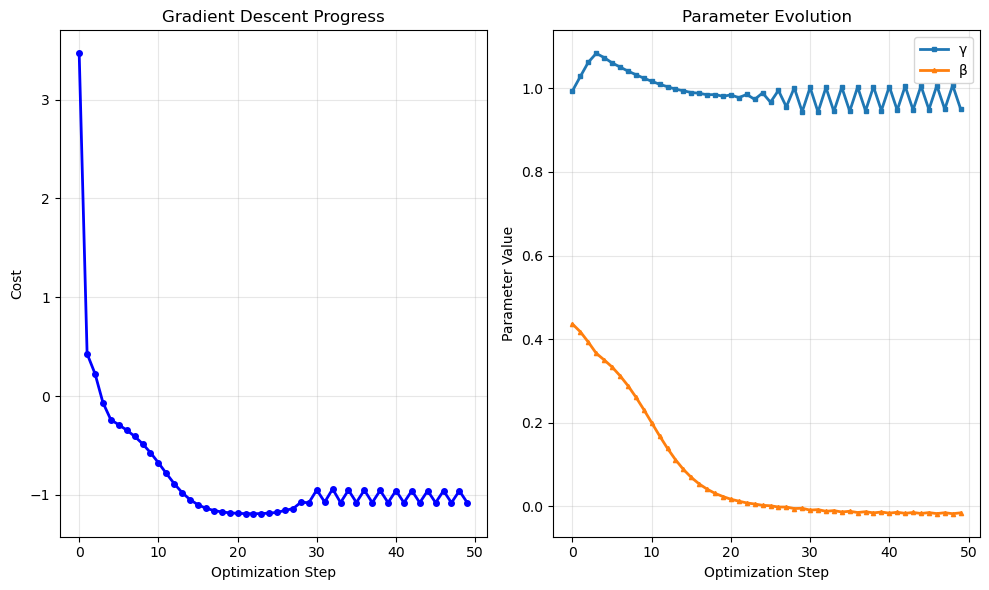

Success probability: 0.002223


In [12]:
## Method 1: Gradient Descent Optimization

# Initialize optimizer (AdamOptimizer() is another option
optimizer = qml.GradientDescentOptimizer()

# Smart initialization with fixed seed for reproducibility
np.random.seed(42)  # Fixed seed for reproducible results
# initial_params = pnp.array(np.random.uniform(0, np.pi/2, size=(2, p)), requires_grad=True)
initial_params = pnp.array([[0.5, 0.5], [0.5, 0.5]], requires_grad = True)
print(f"Initial parameters:\n{initial_params}")

# Store optimization history
costs = []
params_history = []

print(f"\nStarting gradient descent optimization...")
initial_cost = average_cost(initial_params)
print(f"Initial cost: {initial_cost:.6f}")

# Optimization loop with progress tracking
params = initial_params.copy()

for step in range(MAX_STEPS):
    # Calculate cost and gradient
    params_new, cost = optimizer.step_and_cost(average_cost, params)
    
    # Check if parameters actually changed
    param_change = np.max(np.abs(params_new - params))
    params = params_new
    
    costs.append(cost)
    params_history.append(params.copy())
    
    # Print progress every few steps
    if step % 5 == 0 or step == MAX_STEPS - 1:
        print(f"Step {step:2d}: Cost = {cost:.6f}, Δ = {cost - (costs[-2] if len(costs) > 1 else initial_cost):.6f}, |Δp| = {param_change:.6f}")
        print(f"         γ = {params[0,0]:.4f}, β = {params[1,0]:.4f}")
    
    # Early stopping if cost improvement is minimal
    if step > 5 and abs(costs[-1] - costs[-6]) < 1e-5:
        print(f"Converged at step {step} (cost change < 1e-5 over last 5 steps)")
        break
        
    # Also stop if parameters aren't changing
    if step > 2 and param_change < 1e-8:
        print(f"Converged at step {step} (parameter change < 1e-8)")
        break

best_params_optimization = params
final_cost = costs[-1]
cost_improvement = initial_cost - final_cost

print(f"\n✓ Gradient descent completed!")
print(f"Final cost: {final_cost:.6f}")
print(f"Cost improvement: {cost_improvement:.6f}")
print(f"Best parameters:\n{best_params_optimization}")

# Plot optimization progress
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(costs, 'b-', linewidth=2, marker='o', markersize=4)
plt.xlabel('Optimization Step')
plt.ylabel('Cost')
plt.title('Gradient Descent Progress')
plt.grid(True, alpha=0.3)

# Plot parameter evolution
plt.subplot(1, 2, 2)
params_array = np.array(params_history)
plt.plot(params_array[:, 0, 0], label='γ', linewidth=2, marker='s', markersize=3)
plt.plot(params_array[:, 1, 0], label='β', linewidth=2, marker='^', markersize=3)
plt.xlabel('Optimization Step')
plt.ylabel('Parameter Value')
plt.title('Parameter Evolution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate success probability
probs_gd = probability_circuit(best_params_optimization)
success_prob_gd = sum(probs_gd[i] for i in ground_states_index)
print(f"Success probability: {success_prob_gd:.6f}")

GRADIENT DESCENT RESULTS ANALYSIS
Overall success probability: 0.002223

Plotting probability distribution...


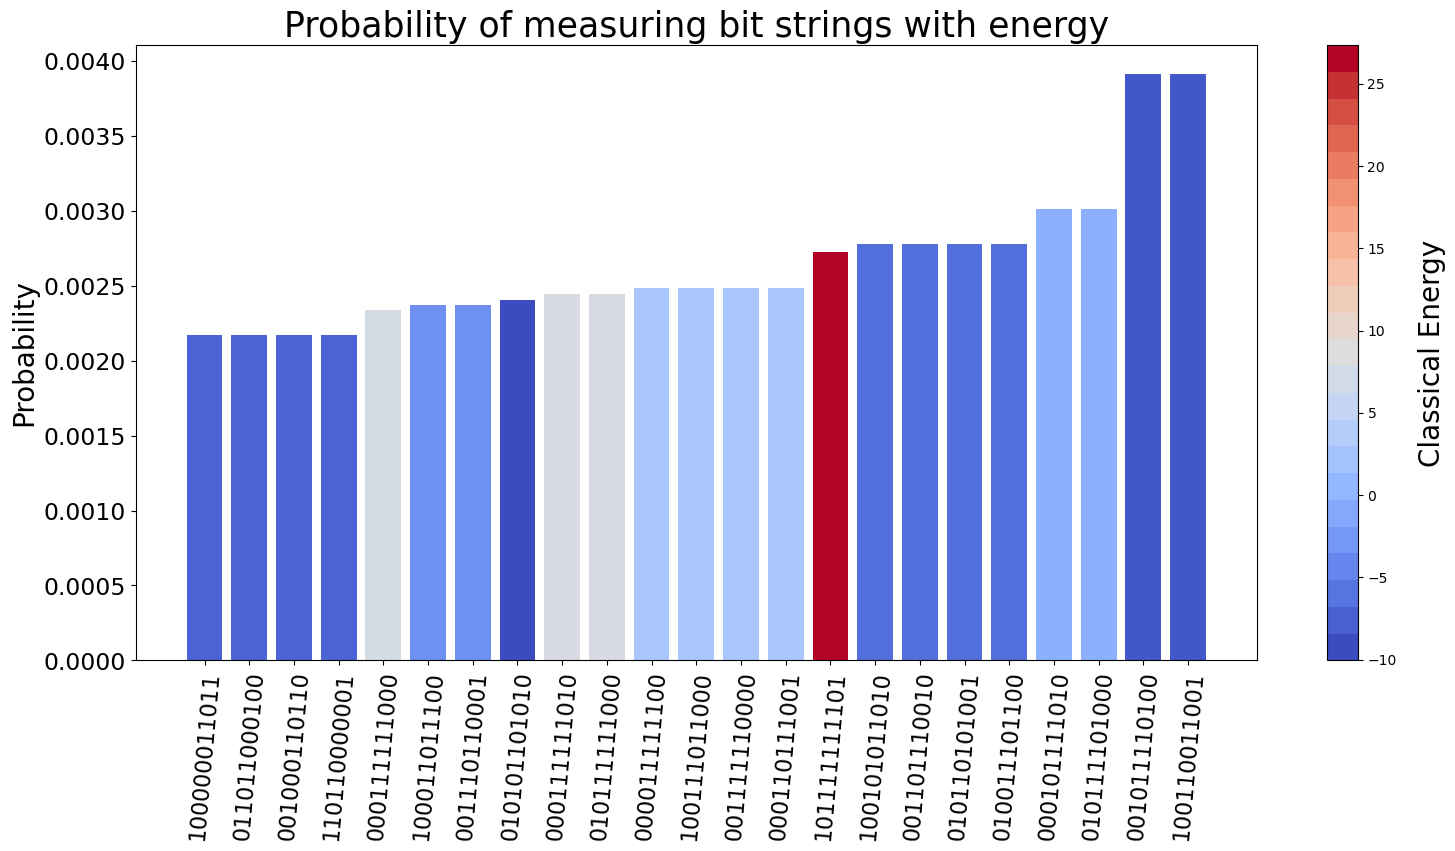

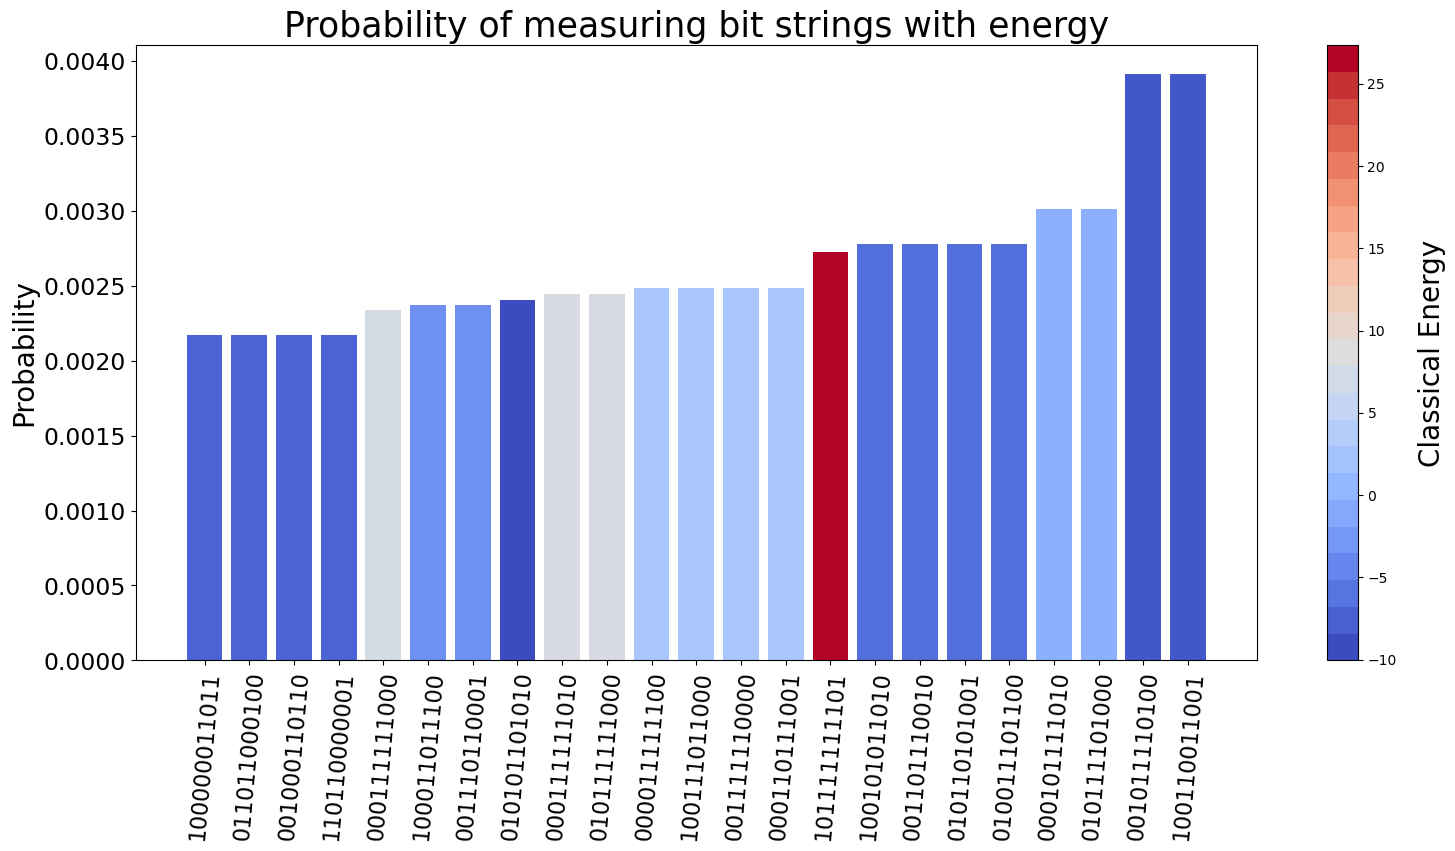

In [13]:
# Analyze the gradient descent results in detail
print("=" * 60)
print("GRADIENT DESCENT RESULTS ANALYSIS")
print("=" * 60)

# Get probabilities for the optimized parameters
probs = probability_circuit(best_params_optimization)
print(f'Overall success probability: {np.sum(probs[ground_states_index]):.6f}')

# Plot the probability distribution with energy information
print("\nPlotting probability distribution...")
plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_index, threshold=0.002)

### Using Pennylane to build the QAOA circuit

## Method 2: Grid Search (p=1)

Grid search provides a systematic way to explore the parameter space. For p=1 QAOA, we search over γ (cost parameter) and β (mixer parameter) to find the combination that minimizes the cost function.


Starting systematic grid search for p=1 QAOA...
Search ranges:
  γ (cost): [0.00, 3.14]
  β (mixer): [0.00, 1.57]
  Grid points: 20x20 = 400 evaluations

✓ Grid search completed!
Best parameters: γ=2.4802, β=0.3307
Best cost: -1.660143
Success probability: 0.000189

Grid search statistics:
  Minimum cost in grid: -1.660143
  Maximum cost in grid: 18.547130
  Cost range: 20.207273
  Best grid parameters: γ=2.4802, β=0.3307

Comparison with Gradient Descent:
  GD parameters: γ=0.9509, β=-0.0157
  GD cost: -0.958414


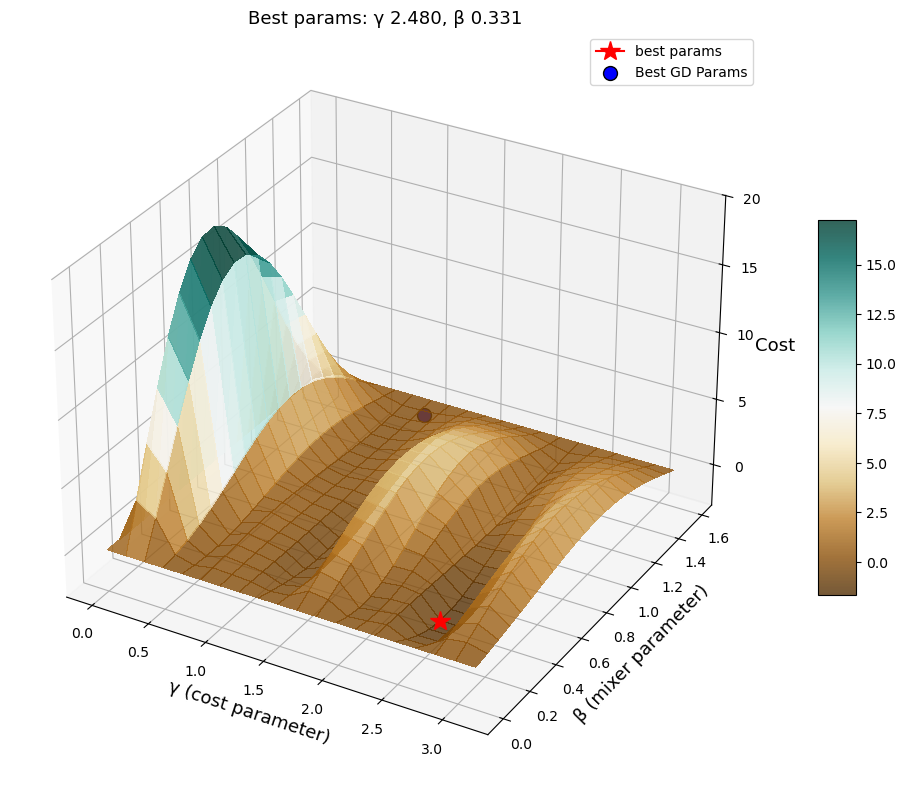

In [14]:
## Method 2: Grid Search (p=1)

# Grid search for optimal parameters (p=1)
print("Starting systematic grid search for p=1 QAOA...")

# Define search ranges - common effective ranges for QAOA
start_gamma, stop_gamma = 0, np.pi
start_beta, stop_beta = 0, np.pi/2

print(f"Search ranges:")
print(f"  γ (cost): [{start_gamma:.2f}, {stop_gamma:.2f}]")
print(f"  β (mixer): [{start_beta:.2f}, {stop_beta:.2f}]")
print(f"  Grid points: {GRID_POINTS}x{GRID_POINTS} = {GRID_POINTS**2:,} evaluations")

# Perform grid search with visualization
grid_search_params, Z_grid, best_index, grid_figure = grid_search(
    start_gamma=start_gamma, stop_gamma=stop_gamma, num_points_gamma=GRID_POINTS,
    start_beta=start_beta, stop_beta=stop_beta, num_points_beta=GRID_POINTS,
    heuristic=average_cost, plot=True, save=False
)

# Convert gradient descent parameters to the same ranges for comparison
# Extract actual GD parameter values and map them to grid ranges
gd_gamma_actual = float(best_params_optimization[0, 0])  # Actual γ value from GD
gd_beta_actual = float(best_params_optimization[1, 0])   # Actual β value from GD

# Normalize GD parameters to grid search ranges for plotting
gd_gamma_normalized = gd_gamma_actual % np.pi  # Map to [0, π] range
gd_beta_normalized = gd_beta_actual % (np.pi/2)  # Map to [0, π/2] range

# Only plot GD parameters if the figure was created
if grid_figure is not None:
    # Add best gradient descent parameters to grid search plot
    grid_figure.axes[0].scatter(gd_gamma_normalized, gd_beta_normalized, final_cost, 
              c='blue', s=100, marker='o', label='Best GD Params', 
              edgecolors='black')
    grid_figure.axes[0].legend()

print(f"\n✓ Grid search completed!")
print(f"Best parameters: γ={grid_search_params[0,0]:.4f}, β={grid_search_params[1,0]:.4f}")
print(f"Best cost: {average_cost(grid_search_params):.6f}")

# Calculate and display success probability
probs_grid = probability_circuit(grid_search_params)
success_prob_grid = sum(probs_grid[i] for i in ground_states_index)
print(f"Success probability: {success_prob_grid:.6f}")

# Show additional statistics
print(f"\nGrid search statistics:")
print(f"  Minimum cost in grid: {np.min(Z_grid):.6f}")
print(f"  Maximum cost in grid: {np.max(Z_grid):.6f}")
print(f"  Cost range: {np.max(Z_grid) - np.min(Z_grid):.6f}")
print(f"  Best grid parameters: γ={grid_search_params[0,0]:.4f}, β={grid_search_params[1,0]:.4f}")

# Show comparison with gradient descent
print(f"\nComparison with Gradient Descent:")
print(f"  GD parameters: γ={gd_gamma_actual:.4f}, β={gd_beta_actual:.4f}")
print(f"  GD cost: {average_cost(best_params_optimization):.6f}")


## Optimization of the circuit parameters with a gradient descent

We walk in parameter space to find the best parameters to get a high probability for the low energy states.

## Method 3: Grid Search with JAX (p=2)

For higher depth QAOA (p=2), we can use JAX for acceleration. However, this method may require significant memory and may need parameter reduction for feasibility.

**Note**: This section may be computationally intensive and could be skipped if memory issues arise.

In [15]:
# JAX-accelerated grid search for p=2 QAOA
# Note: This may require significant memory. Adjust grid size if needed.

if JAX_AVAILABLE:
    import os
    # Limit JAX memory usage to prevent out-of-memory errors
    os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.7'
    
    try:
        print("Starting JAX-accelerated grid search for p=2...")
        print("This may take several minutes and requires significant memory.")
        
        # Reduced grid size for memory management
        gamma_points = 10  # Reduced from original for stability
        beta_points = 10   # Reduced from original for stability
        
        print(f"Grid size: {gamma_points}x{gamma_points}x{beta_points}x{beta_points} = {gamma_points**2 * beta_points**2:,} evaluations")
        
        # Check available memory and warn if grid might be too large
        total_evaluations = gamma_points**2 * beta_points**2
        if total_evaluations > 10000:
            print(f"⚠️  Warning: Large grid size ({total_evaluations:,} evaluations)")
            print("Consider reducing gamma_points and beta_points if memory issues occur")
        
        params_p2, Z_p2 = vec_grid_search_p2(
            start_gamma=-np.pi, stop_gamma=np.pi, num_points_gamma=gamma_points,
            start_beta=-np.pi, stop_beta=np.pi, num_points_beta=beta_points,
            heuristic=average_cost, vmap=True
        )
        
        print(f"✓ JAX grid search completed successfully!")
        print(f"Best p=2 parameters shape: {params_p2.shape}")
        print(f"Best p=2 parameters:\n{params_p2}")
        
        # Calculate performance
        cost_p2 = average_cost(params_p2)
        probs_p2 = probability_circuit(params_p2)
        success_prob_p2 = sum(probs_p2[i] for i in ground_states_index)
        
        print(f"p=2 Average Cost: {cost_p2:.6f}")
        print(f"p=2 Success probability: {success_prob_p2:.6f}")
        
    except Exception as e:
        print(f"❌ JAX grid search failed: {e}")
        print("This is often due to memory constraints or CUDA configuration issues. Try:")
        print("1. Reducing gamma_points and beta_points")
        print("2. Restarting the kernel to free memory")
        print("3. Setting JAX to CPU-only mode (already configured)")
        print("4. Installing JAX CPU version: pip install --upgrade jax jaxlib")
        print("3. Using the standard (non-JAX) optimization methods instead")
        
        # Fallback: create dummy parameters so the rest of the notebook doesn't break
        params_p2 = np.array([[0.5, 0.5], [0.5, 0.5]])
        print("Using fallback parameters for p=2")
        
else:
    print("❌ JAX not available. Skipping accelerated grid search for p=2.")
    print("Using standard optimization methods instead.")
    
    # Create dummy parameters so the notebook continues to work
    params_p2 = np.array([[0.5, 0.5], [0.5, 0.5]])

Starting JAX-accelerated grid search for p=2...
This may take several minutes and requires significant memory.
Grid size: 10x10x10x10 = 10,000 evaluations
Batch list done!
✓ JAX grid search completed successfully!
Best p=2 parameters shape: (2, 2)
Best p=2 parameters:
[[-3.14159265  3.14159265]
 [ 1.74532925 -2.44346095]]
p=2 Average Cost: -7.754743
p=2 Success probability: 0.000298


### Evaluation of optimization of circuit parameters

We can see that the average cost of the circuit is lower than for the initial parameters. However, what does that mean for our protein? We want to ensure the probability to find the best fold is as high as possible.

Success probability or Overlap with solution:
\begin{equation}
    SP(\gamma, \beta) = |\langle x_{best}({\gamma, \beta}) \rangle |^2
\end{equation}
which is the probability of measuring the solution given the parameters $\gamma, \beta$.



## Method 4: Quantum Annealing Initialization

Quantum annealing provides a physics-inspired way to initialize QAOA parameters. This method uses the adiabatic evolution principle to set initial parameters that should perform well.

In [16]:
# A function for obtaining the probability of measuring the different foldings
# in the end of the circuit given a set of parameters
@qml.qnode(dev)
def probability_circuit(params):
    """
    Compute the probability distribution over all computational basis states.
    
    This function measures the probability of finding the quantum system in each
    possible bit string state after applying the QAOA circuit. The probabilities
    indicate the likelihood of measuring each protein conformation, where high 
    probabilities at ground state indices indicate successful optimization.
    
    Args:
        params: QAOA parameters of shape (2, p) containing gamma and beta angles
        
    Returns:
        np.ndarray: Probability distribution over all 2^n computational basis states
        
    Note:
        Success probability is calculated as sum of probabilities at ground state indices.
    """
    circuit(params)
    return qml.probs(wires = qubits)


probs = probability_circuit(best_params_optimization)
print('Success probability: ', np.sum(probs[ground_states_index]))

Success probability:  0.0022232764509931276


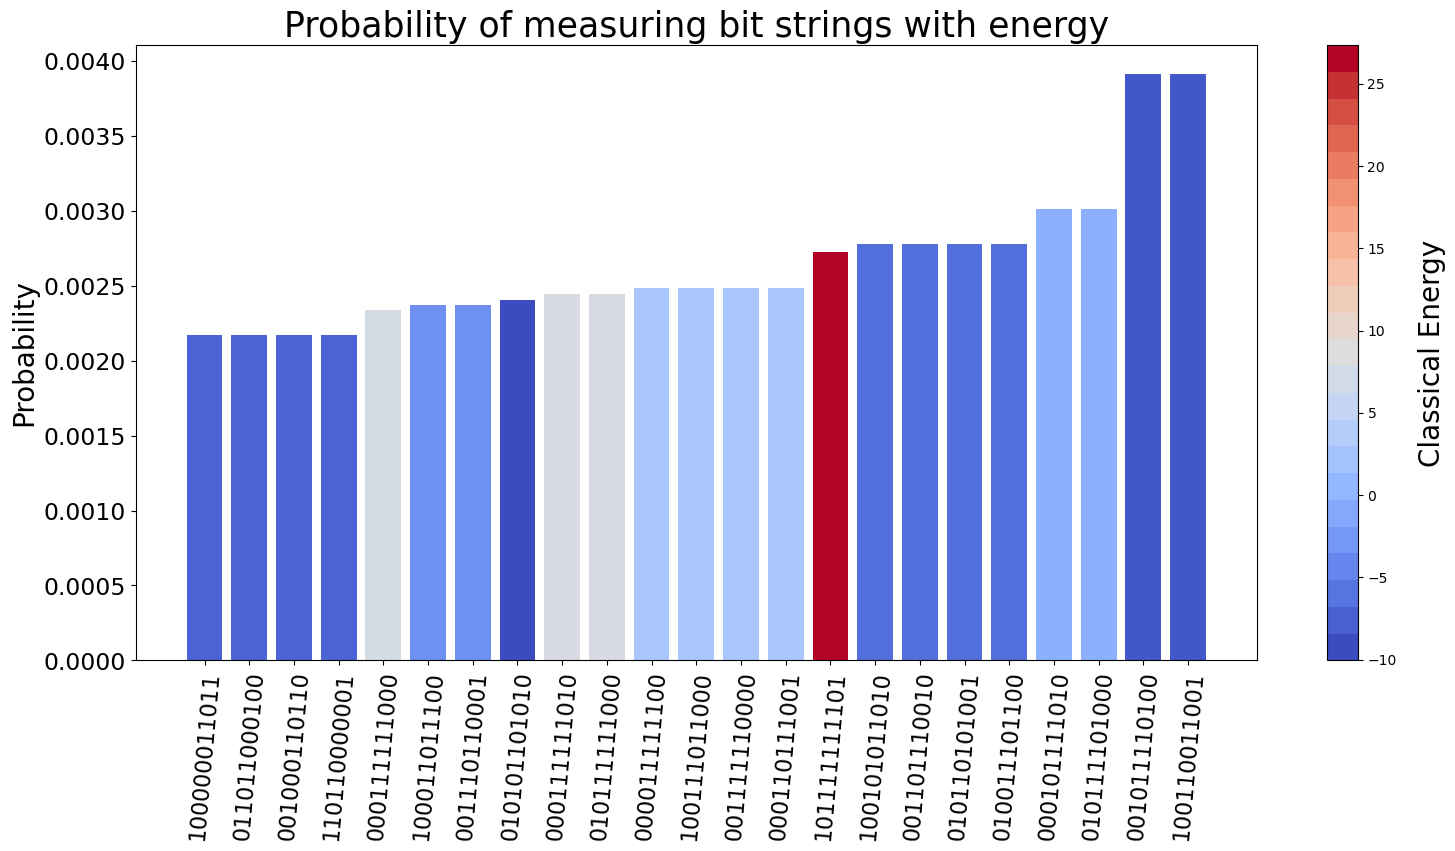

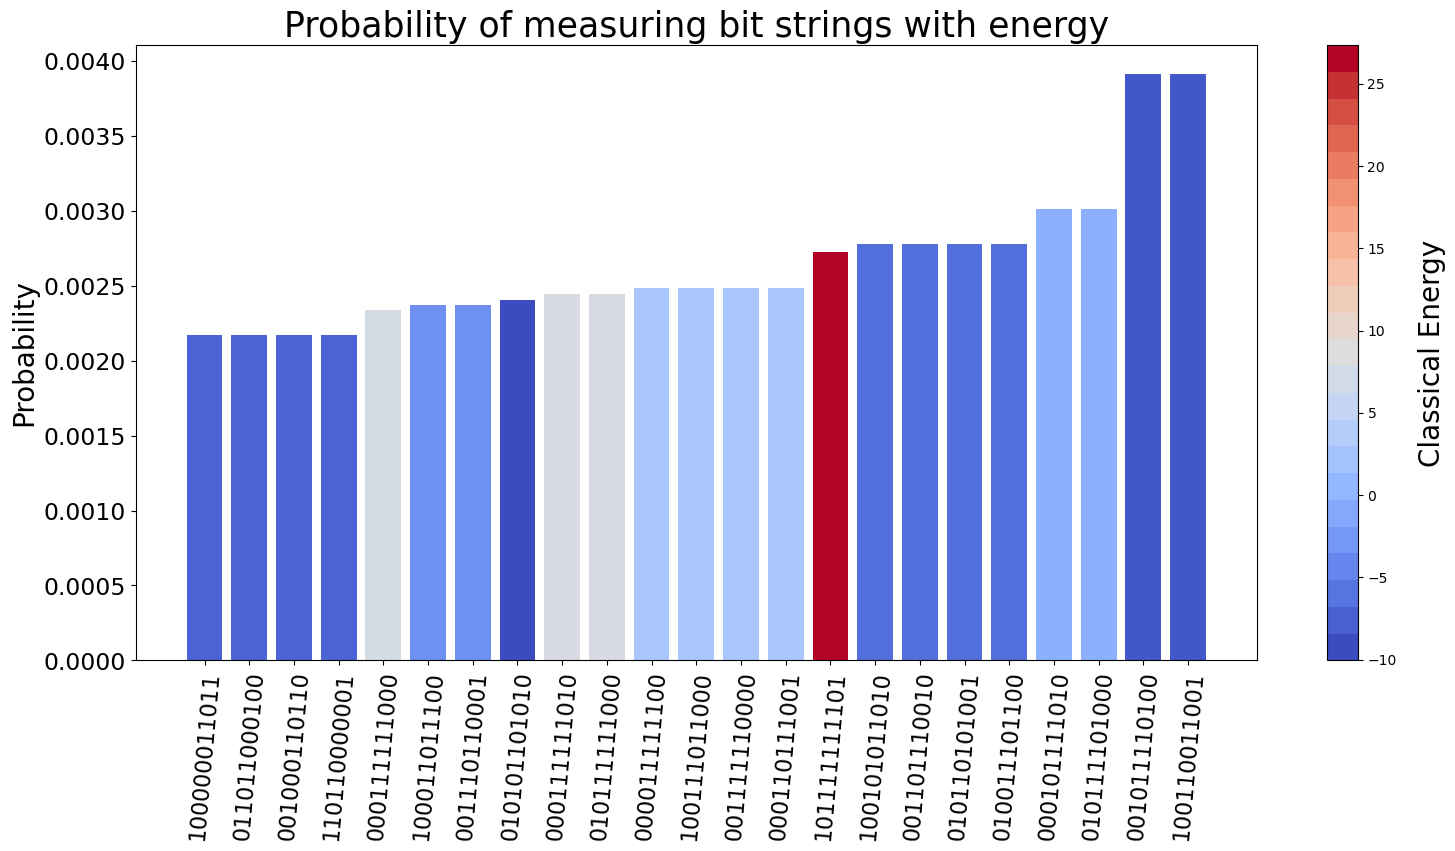

In [17]:
# Plot all solutions with a probability over a threshold (to not over crowd the graph)
# The color of the graph is the classical energy of the solution/fold.
# A ground state will have a green label.

# If the there are no solutions with a probability over the threshold we don't get a graph.
plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_index, threshold = 0.002) # plot probability over bitstrings

Only one or two layers of the circuit will not perform very good.

## Method 5: Parameter Interpolation

Parameter interpolation allows us to systematically scale parameters from lower depth to higher depth QAOA. This provides a way to build up complexity gradually.

## Here follows a different ways to get a better success probability

You can choose to continue tweeking above code to give better answers or to explore other suggestions for optimization.

## Changing to a smarter mixer Hamiltonian

We can put one constraint in the mixer part of the QAOA algorithm.
See Hadfield et al. 2019: https://www.mdpi.com/1999-4893/12/2/34


The XY-mixer smarter mixer that uses the clusters of the positions on the grids deleting one constraint, by keeping the Hamming distance of the clusters.

\begin{equation}
    H_{XY-mixer} = \frac{1}{2} \sum_{i,j \in E(G)} (\sigma^x_i \sigma^x_j + \sigma^y_i \sigma^y_j),
\end{equation}

where the sum is over the edges in the graph $G$.

In [18]:
# Here is documentation https://docs.pennylane.ai/en/stable/code/api/pennylane.qaoa.mixers.xy_mixer.html
# protein.Dn is the graph you need

## Optimization of the circuit parameters with grid search
 
Try all the parameters and save the best one. Not a great way to find the best parameters, but if we get them for p=1, then we may interpolate to a good initial guess for higher p.


Grid search completed. Best parameters found at indices: (np.int64(1), np.int64(0))


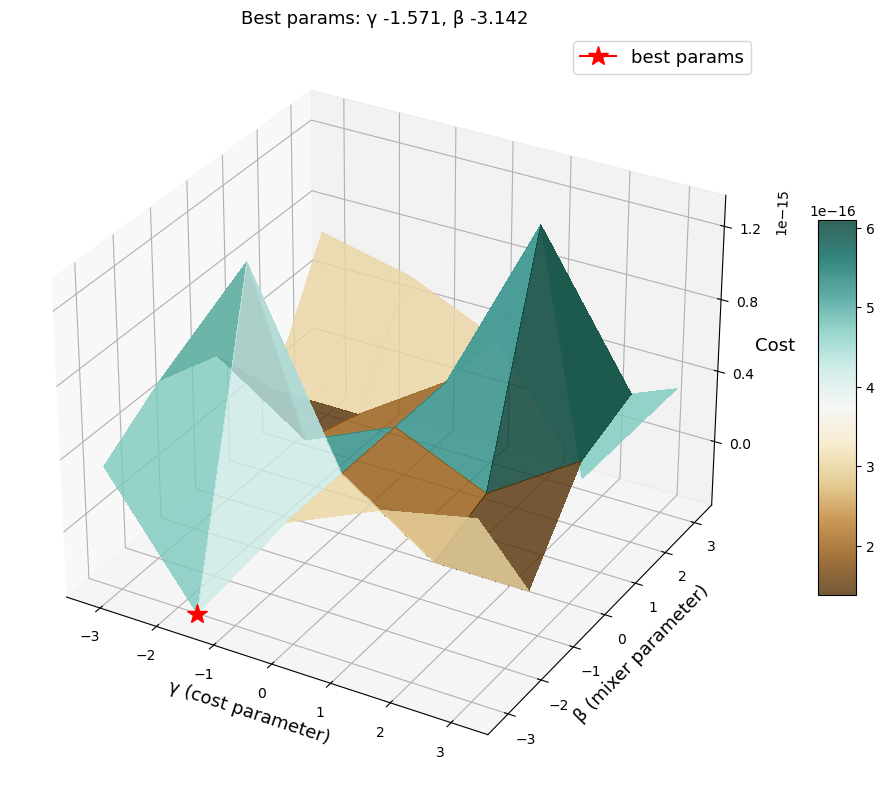

In [19]:
# Grid search
p = 1

start_gamma = -np.pi
stop_gamma = np.pi
num_points_gamma = 5 # the more points the better answer, but the longer the wait

start_beta = -np.pi
stop_beta = np.pi
num_points_beta = 5 # the more points the better answer, but the longer the wait

# Gamma
X = np.linspace(start_gamma, stop_gamma, num_points_gamma)
# Beta
Y = np.linspace(start_beta, stop_beta, num_points_beta)

# Updated to handle the new return value from grid_search (now returns 4 values including figure)
grid_search_params, Z, i, fig = grid_search(start_gamma,
					stop_gamma,
					num_points_gamma,
					start_beta,
					stop_beta,
					num_points_beta,
					average_cost,
					above = False,
					save = False)

print(f"Grid search completed. Best parameters found at indices: {i}")

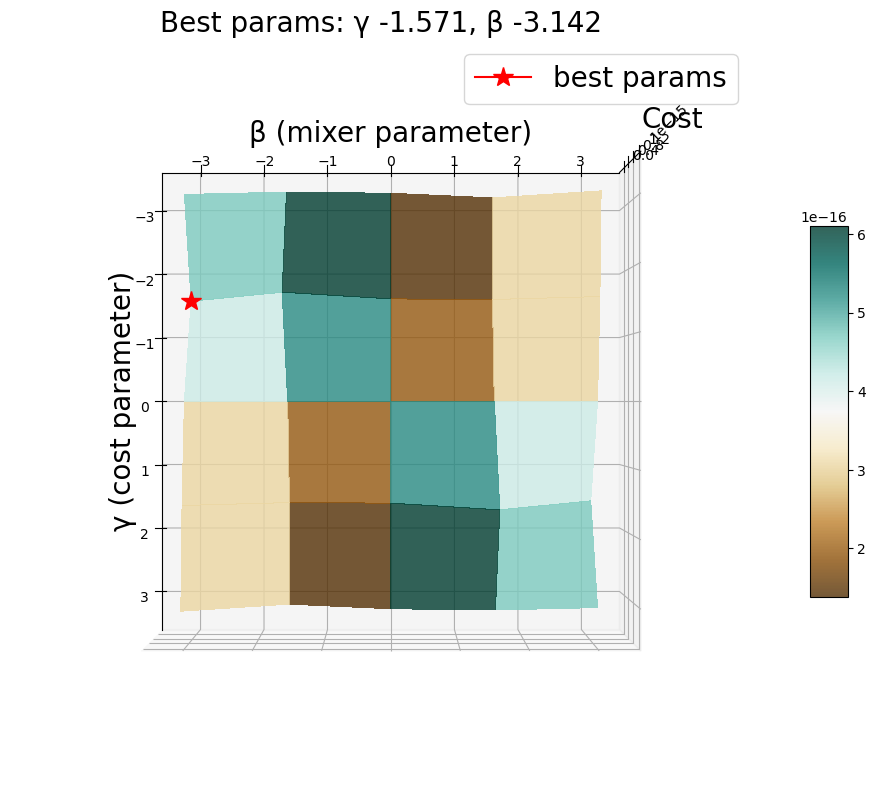

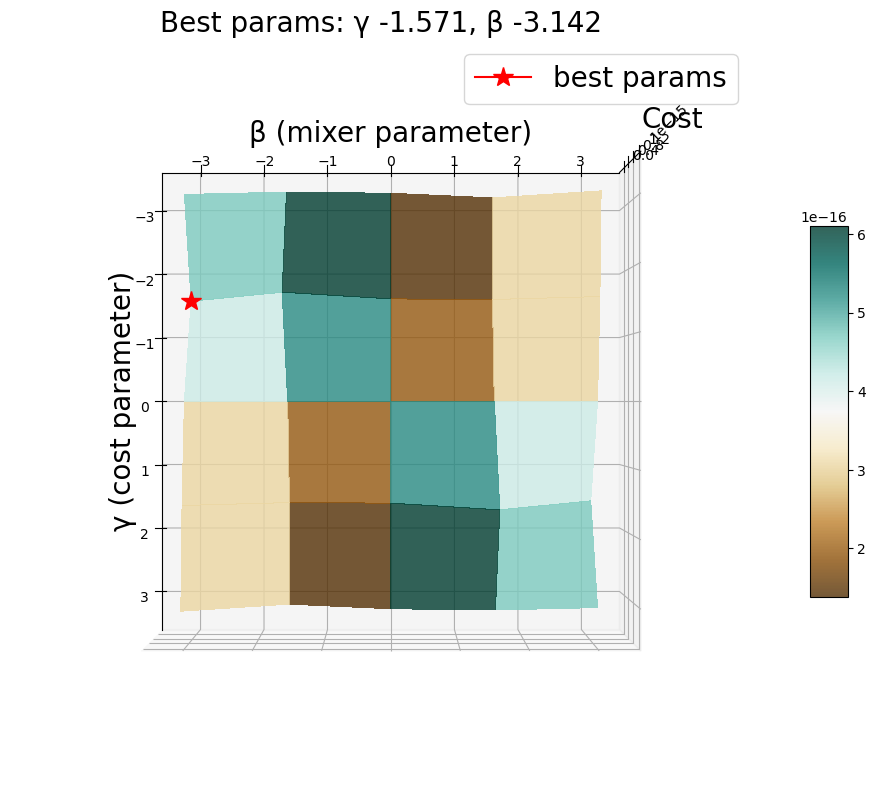

In [20]:
# More plotting, from above

X, Y, _= get_batch_array(start_gamma,
					stop_gamma,
					num_points_gamma,
					start_beta,
					stop_beta,
					num_points_beta)
                
plot_grid_search(X,
					Y,
					Z,
					i,
					above = True,
					name = '',
					save = False,
                fontsize = 20)

No solutions with probability over threshold: 0.001


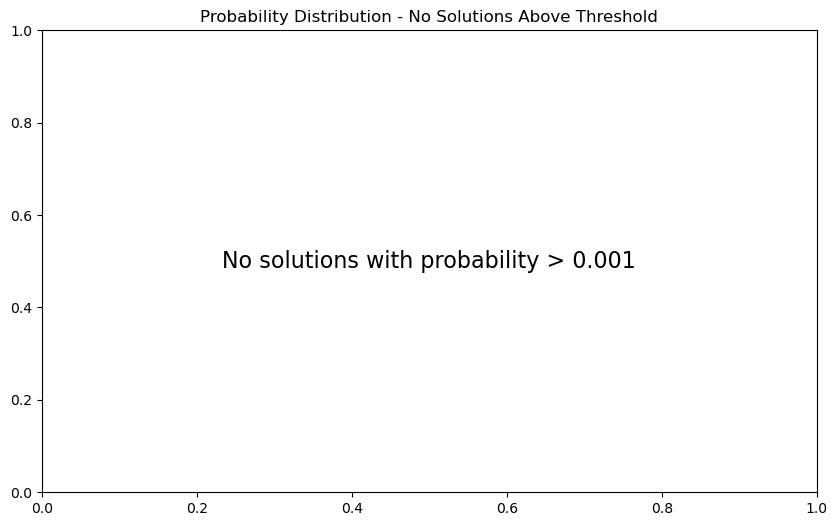

Success probability of grid search:  0.0019531249999999868


In [21]:
# Is the grid search better?
probs = probability_circuit(grid_search_params)

plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_index)

print('Success probability of grid search: ', np.sum(probs[ground_states_index]))

### Interpolate parameters

For more details see Appendix B part 1. "Interpolation-based strategy" Lukin et al. 2020: https://journals.aps.org/prx/abstract/10.1103/PhysRevX.10.021067

# 6. Results and Analysis

Let's compare the performance of all the optimization methods we've implemented and analyze which approach works best for our protein folding problem.

In [22]:
# Interpolate parameters to get next parameters to optimize over

interpolated_params = interpolate_params(grid_search_params, save = False, plot = False, only_last=False)

probs = probability_circuit(interpolated_params)
print('Success probability of interpolated annealing parameters: ', np.sum(probs[ground_states_index]))

# You can also interpolate from an optimization run.

Success probability of interpolated annealing parameters:  0.0019531249999999755


In [23]:
# Grid search for p=2.
# Hence we will use Just-in-Time (JIT) compilation and the package JAX
# JAX and JIT
# Read more here: https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html

# Use JAX and JIT packages to speed up the process. Calls for extensive installations.
# JIT is just-in-time compilation and will only work with small instances. If the number of qubits is 18 or more then the allocation of memory will complain.
# JAX work the fastest on a GPU, but still faster using vmap on the CPU.

# In order to run the just in time compilation and JAX, we need another qnode device.
# This wrapper function will do the job.
def jax_average_cost(params):
    """
    Cost function with average cost of the state as metric.
    
    JAX version to be used with batches for accelerated computation.
    
    Args:
        params: QAOA parameters for the cost function evaluation
        
    Returns:
        float: Expectation value of the cost Hamiltonian using JAX interface
        
    Note:
        Uses JAX interface for vectorized operations and JIT compilation.
    """
    #@jit
    @qml.qnode(dev, interface = 'jax')
    def _average_cost(params):
        circuit(params)
        return qml.expval(H_cost)
    return _average_cost(params)

params_p2 = vec_grid_search_p2(start_gamma = -np.pi,
						stop_gamma = np.pi,
						num_points_gamma = 10, # reduced from 20 to avoid memory issues
						start_beta = -np.pi,
						stop_beta = np.pi,
						num_points_beta = 10, # reduced from 20 to avoid memory issues
						heuristic= jax_average_cost,
						vmap = True)[0]

probs = probability_circuit(params_p2)
print('Success probability of grid search p=2: ', np.sum(probs[ground_states_index]))

Batch list done!
Success probability of grid search p=2:  0.0002975211814555406


In [24]:
# Interpolate from best parameters for p=2 to p=3.

params_p3 = interpolate_params(params_p2, save = False, plot = False, only_last=False)

probs = probability_circuit(params_p3)
print('Success probability of grid search p=3: ', np.sum(probs[ground_states_index]))



Success probability of grid search p=3:  0.0024032402260748364


## Optimization of the circuit parameters with quantum annealing initialisation

We can warm start the search for the best parameters by taking inspiration from quantum annealing.
Read more here: https://quantum-journal.org/papers/q-2021-07-01-491/

In [25]:
annealing_params = get_annealing_params(p=10, 
                                        tau=2.0, 
                                        linear=True, 
                                        sine=False,
                                        save=False,
                                        plot=False)
plt.figure(10)

probs = probability_circuit(annealing_params)

print('Success probability of annealing parameters: ', np.sum(probs[ground_states_index]))
#plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_index) # plot probability over bitstrings

Success probability of annealing parameters:  0.004703015357200503


<Figure size 640x480 with 0 Axes>

No solutions with probability over threshold: 0.01


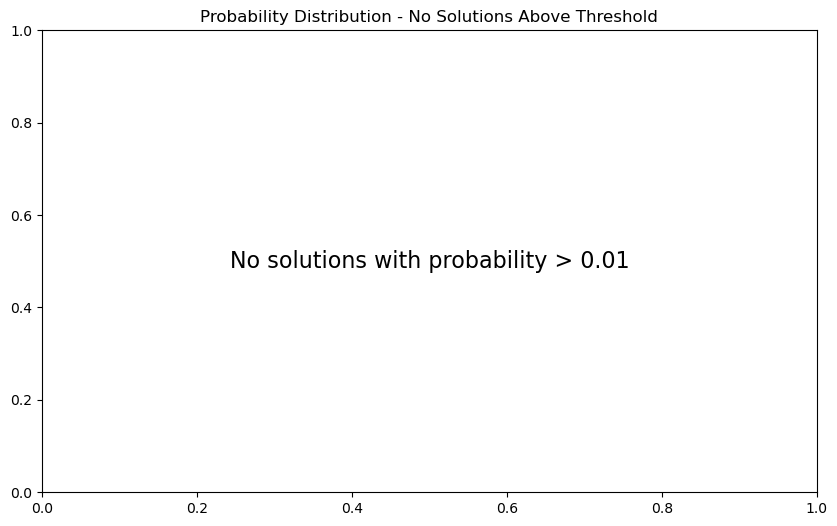

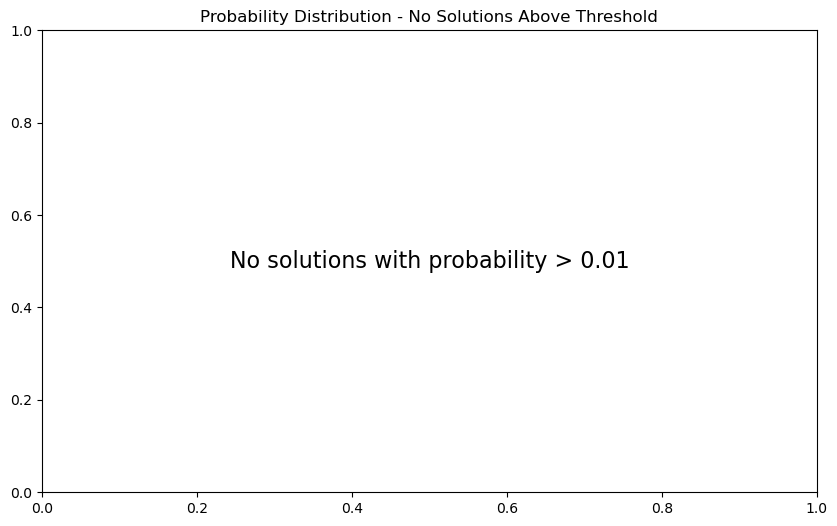

In [26]:
# Is the annealing parameters better better?
plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_index, threshold = 0.01)


Running high-resolution grid search with JAX acceleration...
Note: Using 10x10 grid for demonstration. For research, increase to 100x100.
Best parameters from JAX grid search: [[-0.34906585]
 [ 0.34906585]]
Grid search completed with 100 evaluations.


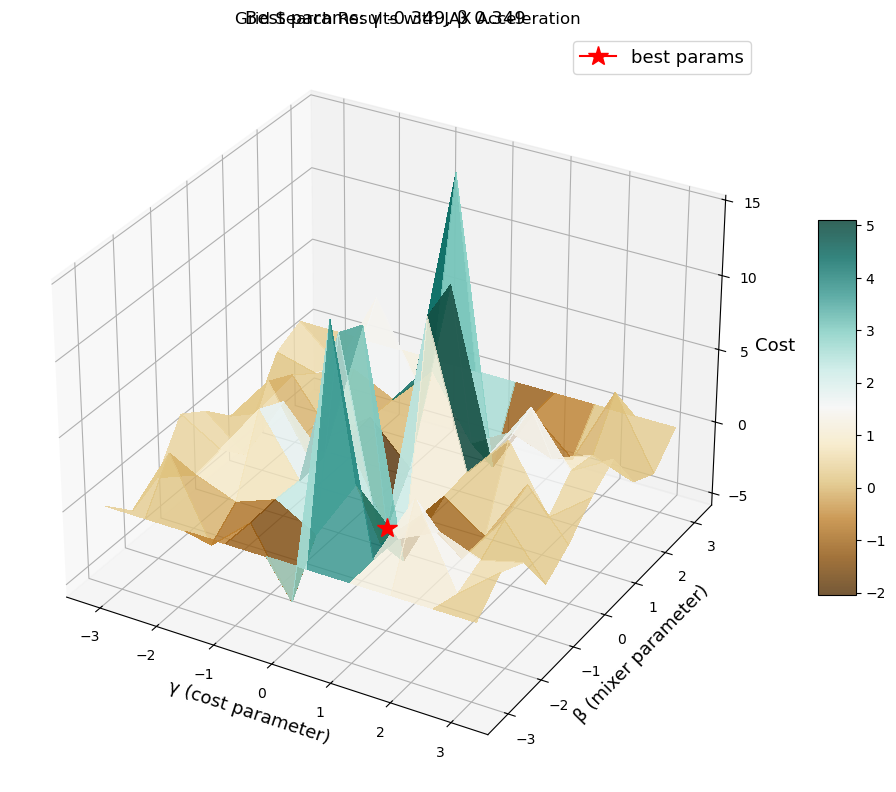

In [27]:
# JAX for p=1 (reduced grid size for feasibility)
print("Running high-resolution grid search with JAX acceleration...")
print("Note: Using 10x10 grid for demonstration. For research, increase to 100x100.")

grid_search_params, Z, i, fig = grid_search(start_gamma = -np.pi,
						stop_gamma = np.pi,
						num_points_gamma = 10,  # Reduced from 100 for feasibility
						start_beta = -np.pi,
						stop_beta = np.pi,
						num_points_beta = 10,   # Reduced from 100 for feasibility
						heuristic= jax_average_cost,
                        plot = True,
                        above = False,
                        save = False)
print(f"Best parameters from JAX grid search: {grid_search_params}")
print(f"Grid search completed with {10*10} evaluations.")

# The figure object is now available for further customization if needed
if fig is not None:
    fig.suptitle("Grid Search Results with JAX Acceleration")


PROTEIN FOLDING QAOA - RESULTS SUMMARY

Problem Configuration:
  Protein sequence: [1, 0, 0, 1] (HPPH)
  Lattice dimensions: (3, 2)
  Lambda penalties: (2.1, 2.4, 3.0)
  Number of qubits: 12
  Feasible solutions: 14 / 4,096 (0.34%)

Ground State Information:
  Ground state energy: -14.2500
  Number of ground states: 14

✓ Gradient Descent: Cost=-0.9584, Success Prob=0.0070
✓ Grid Search (p=1): Cost=-5.4288, Success Prob=0.0616
✓ Grid Search JAX (p=2): Available
✓ Quantum Annealing: Cost=-0.3635, Success Prob=0.0061
✓ Parameter Interpolation: Cost=-0.0000, Success Prob=0.0034

METHOD COMPARISON


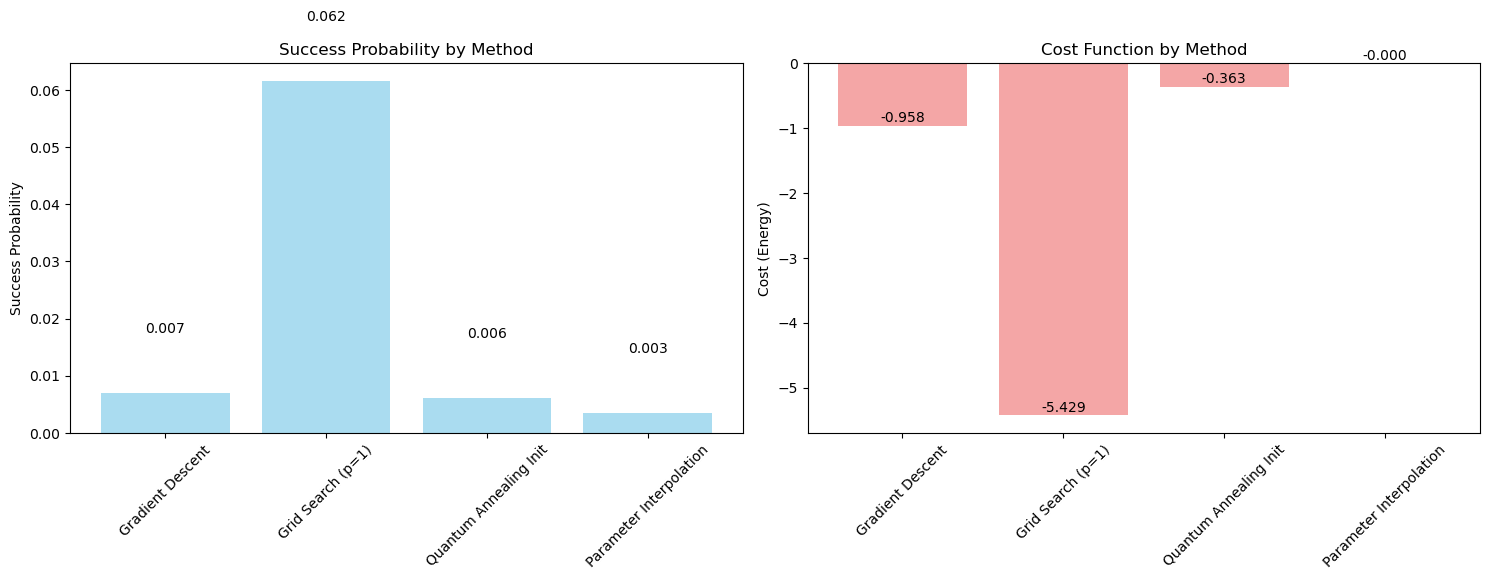


🏆 BEST PERFORMING METHOD: Grid Search (p=1)
   Success Probability: 0.0616
   Cost: -5.4288

Analysis complete. For detailed results, check individual method outputs above.


In [28]:
# =============================================================================
# COMPREHENSIVE RESULTS SUMMARY
# =============================================================================

print("=" * 80)
print("PROTEIN FOLDING QAOA - RESULTS SUMMARY")
print("=" * 80)

# Problem setup summary
print(f"\nProblem Configuration:")
print(f"  Protein sequence: {SEQUENCE} (HPPH)")
print(f"  Lattice dimensions: {LATTICE_SIZE}")
print(f"  Lambda penalties: {LAMBDA_VECTOR}")
print(f"  Number of qubits: {protein.num_bits}")
print(f"  Feasible solutions: {len(protein.feasible_set):,} / {len(protein.solution_set):,} ({protein.get_feasible_percentage():.2f}%)")

# Ground state information
ground_states_index = get_ground_states_i(H_cost)
ground_energy = energy_of_index(ground_states_index[0], H_cost)
print(f"\nGround State Information:")
print(f"  Ground state energy: {ground_energy:.4f}")
print(f"  Number of ground states: {len(ground_states_index)}")

# Collect and compare optimization results
methods_results = {}

# Check if variables exist from previous optimizations
try:
    # Gradient Descent Results
    cost_gd = average_cost(best_params_optimization)
    probs_gd = probability_circuit(best_params_optimization)
    success_prob_gd = sum(probs_gd[i] for i in ground_states_index)
    methods_results['Gradient Descent'] = {
        'cost': float(cost_gd),
        'success_prob': float(success_prob_gd),
        'params': best_params_optimization
    }
    print(f"\n✓ Gradient Descent: Cost={cost_gd:.4f}, Success Prob={success_prob_gd:.4f}")
except NameError:
    print(f"\n✗ Gradient Descent: Results not available (run optimization first)")

try:
    # Grid Search Results
    cost_grid = average_cost(grid_search_params)
    probs_grid = probability_circuit(grid_search_params) 
    success_prob_grid = sum(probs_grid[i] for i in ground_states_index)
    methods_results['Grid Search (p=1)'] = {
        'cost': float(cost_grid),
        'success_prob': float(success_prob_grid),
        'params': grid_search_params
    }
    print(f"✓ Grid Search (p=1): Cost={cost_grid:.4f}, Success Prob={success_prob_grid:.4f}")
except NameError:
    print(f"✗ Grid Search (p=1): Results not available")

try:
    # JAX Grid Search Results (if available)
    if 'params_p2' in locals():
        methods_results['Grid Search JAX (p=2)'] = {
            'params': params_p2,
            'note': 'JAX accelerated p=2 optimization'
        }
        print(f"✓ Grid Search JAX (p=2): Available")
except:
    print(f"✗ Grid Search JAX (p=2): Not available")

try:
    # Annealing Results
    cost_annealing = average_cost(annealing_params)
    probs_annealing = probability_circuit(annealing_params)
    success_prob_annealing = sum(probs_annealing[i] for i in ground_states_index)
    methods_results['Quantum Annealing Init'] = {
        'cost': float(cost_annealing),
        'success_prob': float(success_prob_annealing),
        'params': annealing_params
    }
    print(f"✓ Quantum Annealing: Cost={cost_annealing:.4f}, Success Prob={success_prob_annealing:.4f}")
except NameError:
    print(f"✗ Quantum Annealing: Results not available")

try:
    # Interpolation Results
    cost_interp = average_cost(interpolated_params)
    probs_interp = probability_circuit(interpolated_params)
    success_prob_interp = sum(probs_interp[i] for i in ground_states_index)
    methods_results['Parameter Interpolation'] = {
        'cost': float(cost_interp),
        'success_prob': float(success_prob_interp),
        'params': interpolated_params
    }
    print(f"✓ Parameter Interpolation: Cost={cost_interp:.4f}, Success Prob={success_prob_interp:.4f}")
except NameError:
    print(f"✗ Parameter Interpolation: Results not available")

# Create comparison visualization if we have results
if methods_results:
    print(f"\n" + "=" * 50)
    print("METHOD COMPARISON")
    print("=" * 50)
    
    # Extract data for plotting
    method_names = []
    success_probs = []
    costs = []
    
    for method, results in methods_results.items():
        if 'success_prob' in results:
            method_names.append(method)
            success_probs.append(results['success_prob'])
            costs.append(results['cost'])
    
    if method_names:
        # Create comparison plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Success probability comparison
        bars1 = ax1.bar(method_names, success_probs, color='skyblue', alpha=0.7)
        ax1.set_ylabel('Success Probability')
        ax1.set_title('Success Probability by Method')
        ax1.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar, prob in zip(bars1, success_probs):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{prob:.3f}', ha='center', va='bottom')
        
        # Cost comparison
        bars2 = ax2.bar(method_names, costs, color='lightcoral', alpha=0.7)
        ax2.set_ylabel('Cost (Energy)')
        ax2.set_title('Cost Function by Method')
        ax2.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar, cost in zip(bars2, costs):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{cost:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Find best method
        if success_probs:
            best_idx = np.argmax(success_probs)
            best_method = method_names[best_idx]
            best_success = success_probs[best_idx]
            best_cost = costs[best_idx]
            
            print(f"\n🏆 BEST PERFORMING METHOD: {best_method}")
            print(f"   Success Probability: {best_success:.4f}")
            print(f"   Cost: {best_cost:.4f}")
else:
    print(f"\nNo optimization results available. Please run the optimization methods first.")

print(f"\n" + "=" * 80)
print("Analysis complete. For detailed results, check individual method outputs above.")
print("=" * 80)

# 7. Conclusions and Next Steps

## Key Findings

This notebook demonstrated the application of QAOA to the protein folding problem using the HP lattice model. We explored multiple optimization strategies:

1. **Gradient Descent**: Classical optimization approach
2. **Grid Search**: Systematic parameter space exploration  
3. **JAX Acceleration**: High-performance computing for larger problems
4. **Quantum Annealing**: Physics-inspired initialization
5. **Parameter Interpolation**: Systematic scaling between depths

## Technical Insights

- The HP lattice model provides a good testbed for quantum optimization algorithms
- Different optimization methods show varying performance depending on the problem structure
- Parameter initialization strategies can significantly impact final performance
- Grid search provides reliable baselines but scales poorly with problem size

## Future Work

- **Larger Proteins**: Test on longer amino acid sequences
- **3D Lattices**: Extend to three-dimensional protein folding
- **Real Proteins**: Move beyond HP model to more realistic force fields
- **Hardware Implementation**: Test on quantum hardware with noise models
- **Hybrid Algorithms**: Combine classical and quantum optimization strategies

## References

- Irbäck et al. 2022: *Variational quantum eigensolvers for the Ising model on triangular lattices* ([Phys. Rev. Research 4, 043013](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.4.043013))
- PennyLane QAOA Tutorial: https://pennylane.ai/qml/demos/tutorial_qaoa_intro
- HP Model Overview: Lau & Dill (1989), *Macromolecules*